In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, threading, random, glob, cv2
import keras
import keras.backend as K
from keras.layers import *
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
from keras.applications.resnet50 import ResNet50
import tensorflow as tf
from IPython.display import clear_output

In [ ]:
# Global params
%matplotlib inline

img_size = (224, 224)
batch_size = 16
val_split = 0.1
model_filename = "seedlings.h5"


# Classification labels
plant_labels = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11}

rev_plant_labels = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'}

# Source data loading 
Skip if using saved numpy arrays

In [ ]:
def load_img(file_path):    
    img = cv2.imread(file_path)    
    img = cv2.resize(img, dsize=img_size)
    img = cv2.cvtColor(img[:, :, 0:3], cv2.COLOR_BGR2RGB)    
    return img

def load_training_images():
    img_tmp = []
    label_tmp = []
    print("Loading training images ")
    train_img_paths = glob.glob("train/**/*.png", recursive=True)
    n_files = len(train_img_paths)
    
    for file_index in range(n_files):
        # load image
        img = load_img(train_img_paths[file_index])
        img_tmp.append(img)
        
        path_parts = str.split(train_img_paths[file_index], '\\') # use this with Windows
        #path_parts = str.split(train_img_paths[file_index], '/') # use this with better operating systems
        
        # Get the number label and put it to a list
        label_tmp.append(plant_labels[path_parts[1]])
    
        # Progress monitoring
        if file_index%500 == 0: 
            print(file_index)

    imgs = np.array(img_tmp)
    labels = np.array(label_tmp)
    return imgs, labels

def load_testing_images():
    img_tmp = []
    fname_tmp = []
    test_img_paths = glob.glob("test/*.png", recursive=False)

    n_files = len(test_img_paths)
    print("Loading testing images ")

    for file_index in range(n_files):
        img = load_img(test_img_paths[file_index])
        img_tmp.append(img)
        
        path_parts = str.split(test_img_paths[file_index], '\\') # use this with Windows
        #path_parts = str.split(test_img_paths[file_index], '/') # use this with better operating systems
        
        fname_tmp.append(path_parts[-1])

        # Progress monitoring
        if file_index%100 == 0: 
            print(file_index)

    imgs = np.array(img_tmp)
    filenames = np.array(fname_tmp)
    return imgs, filenames


training_img_array, training_label_array = load_training_images()
training_img_array = training_img_array.astype(np.float32)

testing_img_array, testing_file_names = load_testing_images()
testing_img_array = testing_img_array.astype(np.float32)


# Normalize the images.
# This gives zero mean and unit stdev, which is fine since the model is trained from scratch. 
# If using pre-trained model the scaling will likely have to be done to [-1, 1] range. 

train_img_mean = np.mean(training_img_array)
train_img_std = np.std(training_img_array)

training_img_array -= train_img_mean
training_img_array /= train_img_std

testing_img_array -= train_img_mean
testing_img_array /= train_img_std

print("Image array mean = {} and std = {}".format(train_img_mean, train_img_std))
print("Done!")

In [ ]:
# Print the array shapes to check that everything went fine
print(training_img_array.shape)
print(training_label_array.shape)
print(testing_img_array.shape)
print(testing_file_names.shape)

In [ ]:
# Save the arrays to speed up future work when iterating the model. 
np.save("training_img_array.npy", training_img_array)
np.save("training_label_array.npy", training_label_array)
np.save("testing_img_array.npy", testing_img_array)
np.save("testing_file_names.npy", testing_file_names)

# Load the image arrays

In [ ]:
# Load the arrays if necessary
training_img_array = np.load("training_img_array.npy")
training_label_array = np.load("training_label_array.npy")
testing_img_array = np.load("testing_img_array.npy")
testing_file_names = np.load("testing_file_names.npy")

In [ ]:
print(training_img_array.shape)
print(training_label_array.shape)
print(testing_img_array.shape)
print(testing_file_names.shape)

# Data generators for model training

In [ ]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n = n
        self.bs = bs
        self.shuffle = shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

# Create amplitude ramp in range [0.5, 1.5] for image augmentation.
ramp_aug = np.full(img_size, 0, dtype=np.float32)
incr = 1.0 / float(img_size[1])
for row_index in range(img_size[1]):
    row_value = 0.5 + row_index * incr
    ramp_aug[row_index, :] = row_value

class segm_generator(object):
    def __init__(self, x_arr, y_arr, batch_size=32, train=True):
        self.x_array = x_arr # images
        self.y_array = y_arr # targets
        self.batch_size = batch_size
        self.train = train # train vs. test flag
        self.n_img = x_arr.shape[0] # image quantity
        self.idx_gen = BatchIndices(self.n_img, self.batch_size, self.train)
        
    def get_item(self, idx):
        p_augm = 0.5
        x = self.x_array[idx].copy().astype(np.float32)
        y = self.y_array[idx].copy()
        
        # Amplitude ramp
        if self.train and (random.random() > p_augm):
            if (random.random() > 0.5):
                x[:, :, 0] *= ramp_aug
                x[:, :, 1] *= ramp_aug
                x[:, :, 2] *= ramp_aug                
            else:
                x[:, :, 0] *= ramp_aug.T
                x[:, :, 1] *= ramp_aug.T
                x[:, :, 2] *= ramp_aug.T
        
        # random brightness change
        if self.train and (random.random() > p_augm):
            x *= (0.5 + random.random())
        
        # random color shift
        if self.train and (random.random() > p_augm):
            ch = random.randrange(3)
            x[:, :, ch] *= (0.2 + 2.*random.random())
         
        # Randomly flip vertically
        if self.train and (random.random() > p_augm): 
            x = np.flip(x, axis=0)
            
        # Randomly flip horizontally
        if self.train and (random.random() > p_augm): 
            x = np.flip(x, axis=1)
    
        # Random cropping and zoom  
        if self.train and (random.random() > p_augm):
            cx_loc = random.randrange(100)
            cy_loc = random.randrange(100)
            tmp = x[cy_loc:, cx_loc:, :]
            tmp = cv2.resize(tmp, dsize=img_size)
            x = tmp.copy()

        elif self.train and (random.random() > p_augm):
            # Random stretching
            cx_loc = random.randrange(40)
            cy_loc = random.randrange(40)
            x_slice = img_size[0] - random.randrange(40)
            y_slice = img_size[1] - random.randrange(40)            
            tmp = x[cy_loc:y_slice, cx_loc:x_slice, :].copy()
            tmp = cv2.resize(tmp, dsize=img_size)
            x = tmp.copy()
    
        # Generate one-hot label vector.
        y_vector = np.full(12, 0, dtype=np.int32)
        y_vector[y] = 1
        
        return x, y_vector

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs, ys = zip(*items)
        return np.stack(xs), np.stack(ys)


In [ ]:
# Create sequence generator instances

# Split the training img set to training and validation sets
img_qty = training_img_array.shape[0]
train_indexes = np.full((img_qty), True) 
tmp = np.random.choice(img_qty, int(img_qty * val_split))
train_indexes[tmp] = False
train_imgs = training_img_array[train_indexes==True]
train_labels = training_label_array[train_indexes==True]
test_imgs = training_img_array[train_indexes==False]
test_labels = training_label_array[train_indexes==False]

print(train_imgs.shape)
print(train_labels.shape)
print(test_imgs.shape)
print(test_labels.shape)

# Calculate the set sizes
n_train = int(train_imgs.shape[0] / batch_size)
n_test = int(test_imgs.shape[0] / batch_size)

# Create the generators
train_gen = segm_generator(train_imgs, train_labels, batch_size, train=True)
test_gen = segm_generator(test_imgs, test_labels, batch_size, train=False)

<function matplotlib.pyplot.show>

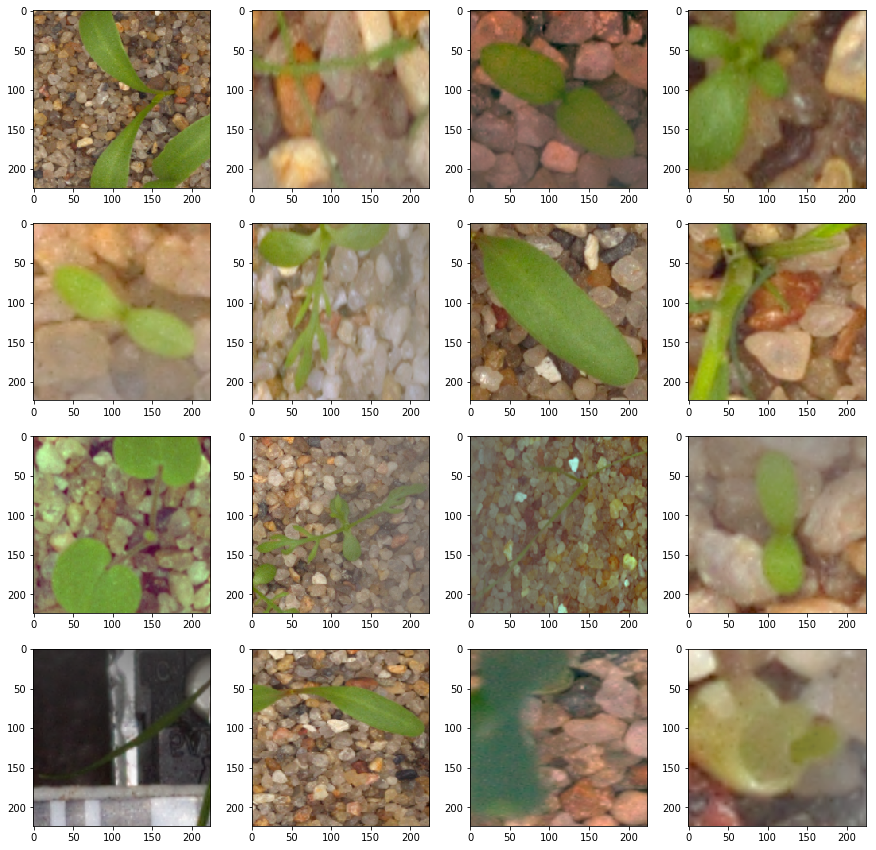

In [58]:
# Test the training sequence generator
tx, ty = train_gen.__next__()
f, axarr = plt.subplots(4,4, figsize=(15,15))

for i in range(len(tx)):
    img = tx[i]
    # Adjust image to pyplot 0...1 range.
    x_min = np.min(img)
    if x_min < 0:
        img -= x_min
    x_max = np.max(img)
    img /= x_max
    axarr[int(i/4)][i%4].imshow(img)

plt.show

# Model

In [59]:
def get_resnet_model():
    model = ResNet50(weights='imagenet')
    model.layers.pop()
    
    # Use this to disable training on the pre-trained layers.
    #for layer in model.layers: 
    #    layer.trainable = False
    
    # recover the output from the last layer in the model and use as input to new Dense layer
    last = model.layers[-1].output
    x = Dense(12, activation="softmax")(last)
    model = Model(model.input, x)

    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Get the model and print the details. 
model = get_resnet_model()
model.summary()

# Training callbacks 
These are used to monitor the trainign progress, to set the learning rate per epoch and to save the model when new lowest val_loss occurs. 

In [3]:

def lr_calculator(epoch, lr=None):
    # This is stateless and calculates lr from the epoch number. 

    lr_baseline = 0.00001
    
    # Adjustable parameters for cyclic mode:
    cyclic = True  # Set True to enable cyclic mode. 
    lr_start_min = 0.0005
    lr_start_max = 0.002
    lr_ramp_steps = 20
    lr_decay_per_cycle = .98
    
    # Decaying smooth lr mode:
    lr_start = 0.001
    lr_decay_per_epoch = 0.99

    # lr calculation
    if cyclic: 
        step_size = (lr_start_max - lr_start_min) / lr_ramp_steps
        cycle = int(epoch / (2 * lr_ramp_steps))
        cycle_phase = int(epoch / lr_ramp_steps) % 2
        cycle_step = epoch % lr_ramp_steps

        if cycle_phase == 1: # Falling phase
            new_lr = lr_start_max - step_size * cycle_step
        else: # Rising phase
            new_lr = lr_start_min + step_size * cycle_step        
        new_lr *= (lr_decay_per_cycle ** epoch)
        new_lr += lr_baseline
        
    else: # not cyclic mode
        new_lr = lr_baseline + lr_start * (lr_decay_per_epoch ** epoch)

    return new_lr

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []   
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.plot_losses()
        
    def get_losses(self):
        return self.losses, self.val_losses
    
    def plot_losses(self):
        # This plots the loss history to a live plot in the training window.
        clear_output(wait=True)
        plt.figure(figsize=(10,8))
        plt.title('Losses')
        plt.xlabel('epoch')
        plt.plot(self.losses, label='loss')
        plt.plot(self.val_losses, label='val_loss')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10,8))
        plt.title('Accuracy')
        plt.xlabel('epoch')
        plt.plot(self.accs, label='acc')
        plt.plot(self.val_accs, label='val_acc')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
        
model_lr = LearningRateScheduler(lr_calculator, verbose=0)
model_losses = LossHistory()
model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1, save_best_only=True)

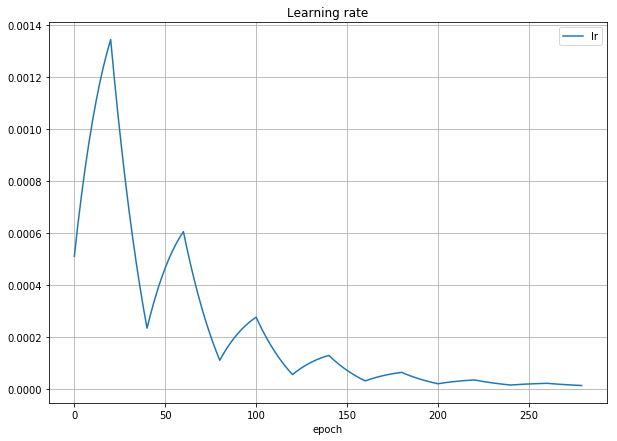

In [7]:
# Plot learning rate curve
lr = [lr_calculator(x) for x in range(280)]
plt.figure(figsize=(10,7))
plt.title('Learning rate')
plt.xlabel('epoch')
plt.plot(lr, label='lr')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Model training

In [ ]:
model.fit_generator(generator=train_gen, steps_per_epoch=n_train, epochs=280, 
                    verbose=1, callbacks=[model_losses, model_lr, model_checkpoint], 
                   validation_data=test_gen, validation_steps=n_test, shuffle=False )



# Testing
This runs the inferences for the testing images and generates csv report for Kaggle submission. 

In [ ]:
test_model = load_model(filepath=model_filename)

n_test = testing_img_array.shape[0]
predictions = []

img_tmp = np.full((1, 224, 224, 3), 0, dtype = np.float32)

for ind in range(n_test):
    prob = test_model.predict(np.expand_dims(testing_img_array[ind], axis=0), verbose=0)
    pred_label = rev_plant_labels[prob.argmax(axis=-1)[0]]
    predictions.append(pred_label)
    if ind%100 == 0:
        print(ind)
        
sub = pd.DataFrame({"file": testing_file_names, "species": predictions})
sub.to_csv("submission.csv", index=False, header=True)
